In [1]:
%matplotlib inline

from copy import deepcopy
from time import time
from collections import OrderedDict

In [2]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck')

from halotools.utils import SampleSelector

hosts, subs = SampleSelector.host_halo_selection(table=halocat.halo_table, return_subhalos=True)

In [3]:
log10_msub_min = 11
subhalo_mpeak_cut = 10**log10_msub_min

log10_mhost_min = max(11.75, log10_msub_min)
log10_mhost_max = 14.75

subhalo_sample_mask = subs['halo_mpeak'] > subhalo_mpeak_cut
subhalo_sample_mask *= subs['halo_mvir_host_halo'] > 10**log10_mhost_min
host_halo_sample_mask = hosts['halo_mvir'] > 10**log10_mhost_min

num_mhost_bins = 25
haloprop_bins = np.logspace(log10_mhost_min, log10_mhost_max, num_mhost_bins)
log10_bin_mids = 0.5*(np.log10(haloprop_bins[:-1]) + np.log10(haloprop_bins[1:]))
bin_mids = 10**log10_bin_mids

from halotools.mock_observables import hod_from_mock

mean_occupation_bolshoi, bin_edges = hod_from_mock(subs['halo_mvir_host_halo'][subhalo_sample_mask], 
                                           hosts['halo_mvir'][host_halo_sample_mask], 
                                                   haloprop_bins)
host_halo_counts_bolshoi = np.histogram(hosts['halo_mvir'][host_halo_sample_mask], 
                                bins=haloprop_bins)[0].astype('f4')
subhalo_counts_bolshoi = np.histogram(subs['halo_mvir_host_halo'][subhalo_sample_mask], 
                                bins=haloprop_bins)[0].astype('f4')


In [4]:
from jiang_usmf import monte_carlo_subhalo_population

def mean_nsub_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2):
    params = dict(beta=beta, zeta=zeta, gamma1=gamma1, alpha1=alpha1, 
                 gamma2=gamma2, alpha2=alpha2)
    mc_nsub, mc_subhalo_mpeak = monte_carlo_subhalo_population(hosts['halo_mvir'][host_halo_sample_mask], 
                                                           log10_msub_min, 
                                                           np.log10(haloprop_bins), **params)
    mean_occupation_model, __ = hod_from_mock(np.repeat(hosts['halo_mvir'][host_halo_sample_mask], mc_nsub), 
                                           hosts['halo_mvir'][host_halo_sample_mask], haloprop_bins)
    return mean_occupation_model

def subhalo_counts_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2):
    params = dict(beta=beta, zeta=zeta, gamma1=gamma1, alpha1=alpha1, 
                 gamma2=gamma2, alpha2=alpha2)
    mc_nsub, mc_subhalo_mpeak = monte_carlo_subhalo_population(hosts['halo_mvir'][host_halo_sample_mask], 
                                                           log10_msub_min, 
                                                           np.log10(haloprop_bins), **params)
    model_subs_mhost = np.repeat(hosts['halo_mvir'][host_halo_sample_mask], mc_nsub)
    return np.histogram(model_subs_mhost, 
                                bins=haloprop_bins)[0].astype('f4') 


def chi2_mean_nsub(params):
    beta, zeta, gamma1, alpha1, gamma2, alpha2 = params
    mean_occupation_model = mean_nsub_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2)
    return np.sum((mean_occupation_model - mean_occupation_bolshoi)**2/host_halo_counts)

def chi2_subhalo_counts(params):
    beta, zeta, gamma1, alpha1, gamma2, alpha2 = params
    
    num_mocks = 1
    chi2_arr = np.zeros(num_mocks)
    for i in range(num_mocks):
        subhalo_counts_model = subhalo_counts_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2)
        chi2_arr[i] = np.sum((subhalo_counts_model - subhalo_counts_bolshoi)**2/host_halo_counts_bolshoi)
    return np.mean(chi2_arr)

    
beta_jiang14 = 5.67
zeta_jiang14 = 1.19
gamma1_jiang14 = 0.13
alpha1_jiang14 = -0.83
gamma2_jiang14 = 1.33
alpha2_jiang14 = -0.02
jiang14_param_dict = OrderedDict()
jiang14_param_dict['beta']=beta_jiang14
jiang14_param_dict['zeta']=zeta_jiang14
jiang14_param_dict['gamma1']=gamma1_jiang14
jiang14_param_dict['alpha1']=alpha1_jiang14
jiang14_param_dict['gamma2']=gamma2_jiang14
jiang14_param_dict['alpha2']=alpha2_jiang14
print(jiang14_param_dict)

print(chi2_subhalo_counts((beta_jiang14, zeta_jiang14, 
              gamma1_jiang14, alpha1_jiang14, 
              gamma2_jiang14, alpha2_jiang14)))

print(chi2_subhalo_counts((beta_jiang14, zeta_jiang14, 
              gamma1_jiang14, -0.925, 
              gamma2_jiang14, alpha2_jiang14)))

OrderedDict([('beta', 5.67), ('zeta', 1.19), ('gamma1', 0.13), ('alpha1', -0.83), ('gamma2', 1.33), ('alpha2', -0.02)])
591601.0
49671.7539062


In [ ]:
from itertools import product
def param_grid_search_generator(**param_iterators):
    param_names = list(param_iterators.keys())
    param_combination_generator = product(*list(param_iterators.values()))
    for param_combination in param_combination_generator:
        yield {param_names[i]: param_combination[i] for i in range(len(param_names))}

In [ ]:
beta_min, beta_max, num_beta = 4.5, 7.5, 10
beta_grid = np.linspace(beta_min, beta_max, num_beta)

alpha1_min, alpha1_max, num_alpha1 = -0.8, -1, 15
alpha1_grid = np.linspace(alpha1_min, alpha1_max, num_alpha1)

gamma2_min, gamma2_max, num_gamma2 = 0.1, 1.5, 25
gamma2_grid = np.linspace(gamma2_min, gamma2_max, num_gamma2)

print("beta_grid = {0}".format(beta_grid))
print("alpha1_grid = {0}".format(alpha1_grid))
print("gamma2_grid = {0}".format(gamma2_grid))


gen = param_grid_search_generator(alpha1=alpha1_grid, beta=beta_grid, gamma2=gamma2_grid)
total_grid_size = len(list(param_grid_search_generator(alpha1=alpha1_grid, beta=beta_grid, gamma2=gamma2_grid)))
print("Total grid size = {0}".format(total_grid_size))

best_fit_param_dict = deepcopy(jiang14_param_dict)

start = time()
best_fit_chi2 = chi2_subhalo_counts(best_fit_param_dict.values())
end = time()
print("Projected runtime = {0} minutes".format((end-start)*total_grid_size/60.))

counter = 0
start = time()
for param_dict in gen:
    counter += 1
    beta = param_dict.get('beta', beta_jiang14)
    zeta = param_dict.get('zeta', zeta_jiang14)
    gamma1 = param_dict.get('gamma1', gamma1_jiang14)
    alpha1 = param_dict.get('alpha1', alpha1_jiang14)
    gamma2 = param_dict.get('gamma2', gamma2_jiang14)
    alpha2 = param_dict.get('alpha2', alpha2_jiang14)
    params = (beta, zeta, gamma1, alpha1, gamma2, alpha2)
    chi2 = chi2_subhalo_counts(params)
    if chi2 < best_fit_chi2:
        best_fit_chi2 = chi2
        best_fit_params = params
        best_fit_param_dict.update(param_dict)
    if counter % 50 == 0:
        print("...working on {0} of {1}".format(counter, total_grid_size))

end = time()
total_runtime = end-start
runtime_per_eval = total_runtime/float(len(list(param_grid_search_generator(alpha1=alpha1_grid, beta=beta_grid, gamma2=gamma2_grid))))
print("\nTotal seconds in the grid search = {0} seconds".format(total_runtime))
print("Seconds per evaluation = {0} seconds\n".format(runtime_per_eval))
print("Best-fit param_dict = ")
print(best_fit_param_dict)

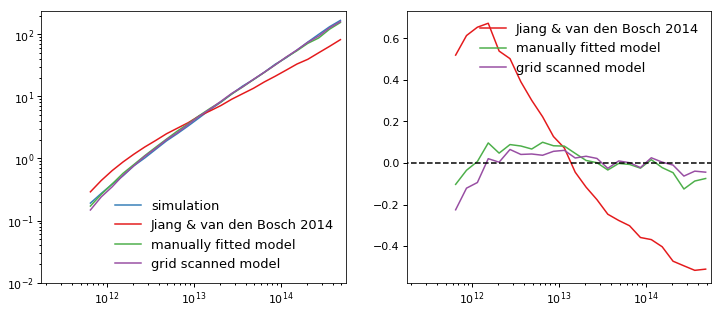

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

mean_occupation_model1 = mean_nsub_prediction(beta_jiang14, zeta_jiang14, 
                                              gamma1_jiang14, alpha1_jiang14, 
                                              gamma2_jiang14, alpha2_jiang14)

beta_jiang14 = 5.67
zeta_jiang14 = 1.19
gamma1_jiang14 = 0.13
alpha1_jiang14 = -0.83
gamma2_jiang14 = 1.33
alpha2_jiang14 = -0.02

beta_new = 4
zeta_new = zeta_jiang14
gamma1_new = gamma1_jiang14
alpha1_new = -0.925
gamma2_new = 0.25
alpha2_new = alpha2_jiang14

mean_occupation_model2 = mean_nsub_prediction(beta_new, zeta_new, 
                                              gamma1_new, alpha1_new, 
                                              gamma2_new, alpha2_new)

beta=4.5
zeta=1.19
gamma1=0.13
alpha1=-0.9285714285714286
gamma2=0.21666666666666667
alpha2=-0.02

mean_occupation_model3 = mean_nsub_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2)

__=ax1.loglog()
__=ax1.plot(bin_mids, mean_occupation_bolshoi, label='simulation', color=blue)
__=ax1.plot(bin_mids, mean_occupation_model1, label='Jiang & van den Bosch 2014', color=red)
__=ax1.plot(bin_mids, mean_occupation_model2, label='manually fitted model', color=green)
__=ax1.plot(bin_mids, mean_occupation_model3, label='grid scanned model', color=purple)

xscale2 = ax2.set_xscale('log')
fracdiff1 = (mean_occupation_model1 - mean_occupation_bolshoi)/mean_occupation_bolshoi
fracdiff2 = (mean_occupation_model2 - mean_occupation_bolshoi)/mean_occupation_bolshoi
fracdiff3 = (mean_occupation_model3 - mean_occupation_bolshoi)/mean_occupation_bolshoi

__=ax2.plot(bin_mids, fracdiff1, label='Jiang & van den Bosch 2014', color=red)
__=ax2.plot(bin_mids, fracdiff2, label='manually fitted model', color=green)
__=ax2.plot(bin_mids, fracdiff3, label='grid scanned model', color=purple)
__=ax2.plot(np.logspace(log10_mhost_min-1, log10_mhost_max+1, 100), np.zeros(100), '--', color='k')

xlim2 = ax2.set_xlim(xmin=10**(log10_mhost_min-0.5), xmax=10**log10_mhost_max)
xlim1 = ax1.set_xlim(xmin=10**(log10_mhost_min-0.5), xmax=10**log10_mhost_max)
ylim1 = ax1.set_ylim(ymin=0.01)


legend1 = ax1.legend()
legend2 = ax2.legend()



In [7]:
more best_fit_param_dict.txt